# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter_function=lambda variableId: 
                                                    variableId.getId().startswith('observable_') and not variableId.getId().endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': {'name': 'observable_x1', 'formula': 'x1'}, 'observable_x2': {'name': 'observable_x2', 'formula': 'x2'}, 'observable_x3': {'name': 'observable_x3', 'formula': 'x3'}, 'observable_x1_scaled': {'name': 'observable_x1_scaled', 'formula': 'scaling_x1 * x1'}, 'observable_x2_offsetted': {'name': 'observable_x2_offsetted', 'formula': 'offset_x2 + x2'}, 'observable_x1withsigma': {'name': 'observable_x1withsigma', 'formula': 'x1'}}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7f57cd0b2ed0> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

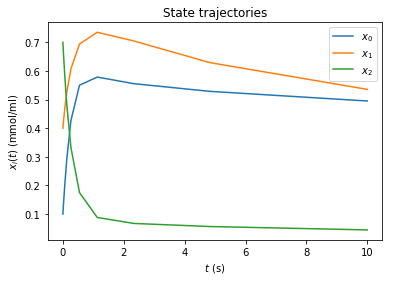

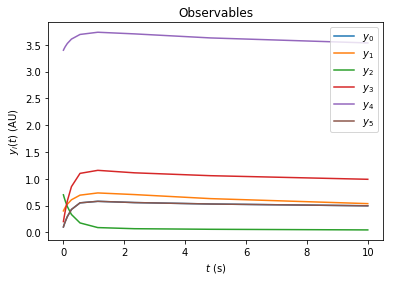

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [9]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters.copy()
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters:\t%s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters:\t%s' % default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    print()
    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
        print()
            
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    print("\tSigma mean per observable:", sigmay.mean(axis=0))
    measurement[:, sigma_parameter_observable_idx] = np.random.normal(
        loc=rdata['y'][:, sigma_parameter_observable_idx], 
        scale=simulationParameters[sigma_parameter_idx])
    print("\tMean abs. relative measurement error per observable:")
    print("\t", np.mean(np.abs((measurement-rdata['y'])/rdata['y']), axis=0))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.SensitivityMethod_forward)
    solver.setSensitivityOrder(amici.SensitivityOrder_first)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

df, conditionDf = createData()

true_parameters:	[1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:	[1.  0.5 0.4 2.  0.1 2.  3.  0.2]

Condition 0: [1.]
	Sigma mean per observable: [0.1 0.1 0.1 0.1 0.1 nan]
	Mean abs. relative measurement error per observable:
	 [0.46024986 0.16724645 0.34471509 0.2712193  0.02447721 0.9969971 ]
	llh:  0.0
	sllh [0. 0. 0. 0. 0. 0. 0. 0.]

Condition 1: [1.1]
	Sigma mean per observable: [0.1 0.1 0.1 0.1 0.1 nan]
	Mean abs. relative measurement error per observable:
	 [0.59282055 0.13139843 0.44869629 0.26982686 0.01379034 1.21203717]
	llh:  0.0
	sllh [0. 0. 0. 0. 0. 0. 0. 0.]

Condition 2: [1.2]
	Sigma mean per observable: [0.1 0.1 0.1 0.1 0.1 nan]
	Mean abs. relative measurement error per observable:
	 [0.32638946 0.20200164 0.30583964 0.30165771 0.02015047 0.93231533]
	llh:  0.0
	sllh [0. 0. 0. 0. 0. 0. 0. 0.]

Condition 3: [1.3]
	Sigma mean per observable: [0.1 0.1 0.1 0.1 0.1 nan]
	Mean abs. relative measurement error per observable:
	 [0.46401252 0.15602032 0.26100741 0.290

In [10]:
df

,observable,condition,conditionRef,scalingParameter,time,measurement,sigma
0,observable_x1,condition-0,,,0.000010,0.256009,0.1
1,observable_x1,condition-0,,,0.000021,0.093710,0.1
2,observable_x1,condition-0,,,0.000043,0.043287,0.1
3,observable_x1,condition-0,,,0.000089,0.126243,0.1
4,observable_x1,condition-0,,,0.000183,0.192217,0.1
5,observable_x1,condition-0,,,0.000379,0.007803,0.1
6,observable_x1,condition-0,,,0.000785,0.099243,0.1
7,observable_x1,condition-0,,,0.001624,0.137591,0.1
8,observable_x1,condition-0,,,0.003360,-0.032161,0.1
9,observable_x1,condition-0,,,0.006952,0.155274,0.1


In [11]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [13]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0

hdf5FileMinibatch = 'example_data_minibatch.h5'
!cp {hdf5File} {hdf5FileMinibatch}

Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Parameter scaling_x1_common selected as proportionality factor for hierarchical optimization (scaling_x1*x1).
Number of proportionality factors for hierarchical optimization: 1


In [14]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(10):
        parameters = true_parameters_scaled
        parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters

!cp {hdf5File} {hdf5FileMinibatch}

In [15]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 2
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            2
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [16]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


[2018-12-01 20:33:16] [ERR] [-1/]     0 g:  2.38418e+09  fd_c:            0  Δ/fd_c: 2.384179e+14  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     1 g: -3.55203e+08  fd_c:            0  Δ/fd_c: -3.552033e+13  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     2 g: -1.11343e+11  fd_c:            0  Δ/fd_c: -1.113435e+16  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     3 g:  8.05479e+11  fd_c:            0  Δ/fd_c: 8.054789e+16  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     4 g:  2.51274e+09  fd_c:            0  Δ/fd_c: 2.512736e+14  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     5 g:     -74.0114  fd_c:            0  Δ/fd_c: -7.401145e+06  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     6 g:  4.04276e+12  fd_c:            0  Δ/fd_c: 4.042759e+17  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     7 g:      184.202  fd_c:            0  Δ/fd_c: 1.842023e+07  f:  2.73618e+21
[2018-12-01 20:33:16] [ERR] [-1/]     8 g:   2.3549e+12  fd_c:            0  

## Optimize

In [17]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
Scanning dependencies of target model_steadystate_scaled
[  7%] Built target parpecommon
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparse.cpp.o
-- Building version parPE-v0.1.8-67-g672a-dirty
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JvB.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jy.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystat

CMakeFiles/unittests_amici.dir/__/src/simulationResultWriterTest.cpp.o: In function `TEST_simulationResultWriter_testResultWriter_Test::testBody()':
/home/dweindl/src/parPE/amici/src/simulationResultWriterTest.cpp:30: warning: the use of `tmpnam' is dangerous, better use `mkstemp'
[ 94%] Built target unittests_amici
[ 95%] Linking CXX executable example_steadystate_multi_simulator
[ 96%] Linking CXX executable example_steadystate_parallel
[ 97%] Linking CXX executable example_steadystate_multi
[ 97%] Built target example_steadystate_parallel
[ 97%] Built target example_steadystate_multi_simulator
[ 97%] Built target example_steadystate_multi
[ 98%] Linking CXX executable test_steadystate
CMakeFiles/test_steadystate.dir/__/__/__/common/src/testingMisc.cpp.o: In function `parpe::captureStreamToString[abi:cxx11](std::function<void ()> const&, _IO_FILE*, int)':
/home/dweindl/src/parPE/common/src/testingMisc.cpp:72: warning: the use of `tmpnam' is dangerous, better use `mkstemp'
[100%] Buil

[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c1] Result for 1: -393.055 (0) (0.0013s-)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c2] Result for 2: -481.064 (0) (0.0013s-)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c3] Result for 3: -378.38 (0) (0.0013s-)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c0] Result for 0: -521.675 (0) (0.0149s+)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c1] Result for 1: -393.055 (0) (0.0148s+)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c2] Result for 2: -481.064 (0) (0.0150s+)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i2c3] Result for 3: -378.38 (0) (0.0159s+)
[2018-12-01 20:33:58] [INF] [-1/] [o0i2] iter: 2 cost: 1774.17 time_iter: wall: 0.156726s cpu: 0.10239s time_optim: wall: 0.411921s cpu: 0.27188s
   2  1.7741740e+03 0.00e+00 2.91e+04   7.2 2.95e+03    -  1.00e+00 1.84e-04f  4
[2018-12-01 20:33:58] [DBG] [-1/] [o0i3c0] Result for 0: -379.253 (0) (0.0013s-)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i3c1] Result for 1: -357.187 (0) (0.0013s-)
[2018-12-01 20:33:58] [DBG] [-1/] [o0i3c2] Res

[2018-12-01 20:33:59] [INF] [-1/] [o0i10] iter: 10 cost: 870.072 time_iter: wall: 0.101085s cpu: 0.0658031s time_optim: wall: 1.10986s cpu: 0.71833s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.7007187e+02 0.00e+00 4.36e+01   1.7 4.10e-01    -  1.00e+00 1.00e+00f  1
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c0] Result for 0: -209.898 (0) (0.0014s-)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c1] Result for 1: -204.71 (0) (0.0013s-)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c2] Result for 2: -209.979 (0) (0.0012s-)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c3] Result for 3: -206.548 (0) (0.0013s-)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c0] Result for 0: -209.898 (0) (0.0153s+)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c1] Result for 1: -204.71 (0) (0.0151s+)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c2] Result for 2: -209.979 (0) (0.0156s+)
[2018-12-01 20:33:59] [DBG] [-1/] [o0i11c3] Result for 3: -206.548 (0) (0.0150s+)
[2018-12-01 20:33:59] [INF] [-1/] [

[2018-12-01 20:34:00] [DBG] [-1/] [o0i18c1] Result for 1: 72.7102 (0) (0.0108s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i18c2] Result for 2: 80.8116 (0) (0.0110s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i18c3] Result for 3: 77.4055 (0) (0.0110s+)
[2018-12-01 20:34:00] [INF] [-1/] [o0i18] iter: 18 cost: -304.437 time_iter: wall: 0.0761679s cpu: 0.0477959s time_optim: wall: 1.90872s cpu: 1.23972s
  18 -3.0443724e+02 0.00e+00 6.65e+01  -1.0 6.22e-02    -  9.99e-01 1.00e+00f  1
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c0] Result for 0: 71.3085 (0) (0.0014s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c1] Result for 1: 74.9175 (0) (0.0010s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c2] Result for 2: 80.0689 (0) (0.0009s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c3] Result for 3: 84.1383 (0) (0.0009s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c0] Result for 0: 71.3085 (0) (0.0153s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i19c1] Result for 1: 74.9175 (0) (0.0113s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i1

[2018-12-01 20:34:00] [DBG] [-1/] [o0i25c2] Result for 2: 105.126 (0) (0.0114s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i25c3] Result for 3: 109.134 (0) (0.0133s+)
[2018-12-01 20:34:00] [INF] [-1/] [o0i25] iter: 25 cost: -405.247 time_iter: wall: 0.0974191s cpu: 0.0617535s time_optim: wall: 2.51355s cpu: 1.63685s
  25 -4.0524655e+02 0.00e+00 7.35e+00 -11.0 1.22e-01    -  1.00e+00 5.00e-01f  2
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c0] Result for 0: 95.3329 (0) (0.0010s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c1] Result for 1: 96.6661 (0) (0.0010s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c2] Result for 2: 105.412 (0) (0.0010s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c3] Result for 3: 108.89 (0) (0.0013s-)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c0] Result for 0: 95.3329 (0) (0.0114s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c1] Result for 1: 96.6661 (0) (0.0146s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26c2] Result for 2: 105.412 (0) (0.0123s+)
[2018-12-01 20:34:00] [DBG] [-1/] [o0i26

[2018-12-01 20:34:01] [DBG] [-1/] [o0i32c1] Result for 1: 96.8071 (0) (0.0151s+)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i32c2] Result for 2: 105.389 (0) (0.0122s+)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i32c3] Result for 3: 108.753 (0) (0.0135s+)
[2018-12-01 20:34:01] [INF] [-1/] [o0i32] iter: 32 cost: -406.463 time_iter: wall: 0.117529s cpu: 0.0754923s time_optim: wall: 3.19889s cpu: 2.08144s
  32 -4.0646321e+02 0.00e+00 2.24e+00 -11.0 4.02e-02    -  1.00e+00 5.00e-01f  2
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c0] Result for 0: 94.2808 (0) (0.0010s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c1] Result for 1: 95.3475 (0) (0.0009s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c2] Result for 2: 103.716 (0) (0.0010s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c3] Result for 3: 108.205 (0) (0.0011s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c0] Result for 0: 94.2808 (0) (0.0010s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33c1] Result for 1: 95.3475 (0) (0.0010s-)
[2018-12-01 20:34:01] [DBG] [-1/] [o0i33

[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c0] Result for 0: -17.6684 (0) (0.0012s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c1] Result for 1: -49.2444 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c2] Result for 2: -25.4766 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c3] Result for 3: -64.9773 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c0] Result for 0: -17.6684 (0) (0.0013s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c1] Result for 1: -49.2444 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c2] Result for 2: -25.4766 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c3] Result for 3: -64.9773 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c0] Result for 0: 93.1984 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c1] Result for 1: 86.8187 (0) (0.0011s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c2] Result for 2: 96.1494 (0) (0.0013s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i37c3] Result for 3: 88.7713 (0) (0.0010s-)
[2018-12-01 20:34:02

[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c0] Result for 0: 95.0778 (0) (0.0012s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c1] Result for 1: 96.7596 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c2] Result for 2: 102.055 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c3] Result for 3: 104.325 (0) (0.0014s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c0] Result for 0: 96.1852 (0) (0.0009s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c1] Result for 1: 97.5076 (0) (0.0010s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c2] Result for 2: 104.131 (0) (0.0009s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c3] Result for 3: 106.809 (0) (0.0010s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c0] Result for 0: 96.3172 (0) (0.0013s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c1] Result for 1: 97.4655 (0) (0.0015s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c2] Result for 2: 104.802 (0) (0.0015s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i41c3] Result for 3: 107.711 (0) (0.0015s-)
[2018-12-01 20:34:02] [DBG] 

[2018-12-01 20:34:02] [DBG] [-1/] [o0i44c2] Result for 2: 105.191 (0) (0.0120s+)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i44c3] Result for 3: 108.302 (0) (0.0119s+)
[2018-12-01 20:34:02] [INF] [-1/] [o0i44] iter: 44 cost: -406.817 time_iter: wall: 0.148075s cpu: 0.0977741s time_optim: wall: 4.64261s cpu: 3.04174s
  44 -4.0681679e+02 0.00e+00 1.33e-01 -11.0 6.75e-02    -  1.00e+00 3.12e-02f  6
[2018-12-01 20:34:02] [DBG] [-1/] [o0i45c0] Result for 0: 96.2496 (0) (0.0013s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i45c1] Result for 1: 97.2079 (0) (0.0011s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i45c2] Result for 2: 105.104 (0) (0.0010s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i45c3] Result for 3: 108.25 (0) (0.0011s-)
[2018-12-01 20:34:02] [DBG] [-1/] [o0i45c0] Result for 0: 96.2496 (0) (0.0009s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i45c1] Result for 1: 97.2079 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i45c2] Result for 2: 105.104 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i45c

[2018-12-01 20:34:03] [DBG] [-1/] [o0i48c0] Result for 0: 96.3924 (0) (0.0121s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i48c1] Result for 1: 97.16 (0) (0.0152s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i48c2] Result for 2: 105.15 (0) (0.0115s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i48c3] Result for 3: 108.14 (0) (0.0131s+)
[2018-12-01 20:34:03] [INF] [-1/] [o0i48] iter: 48 cost: -406.842 time_iter: wall: 0.132308s cpu: 0.08757s time_optim: wall: 5.08373s cpu: 3.33215s
  48 -4.0684229e+02 0.00e+00 2.41e-01 -11.0 5.43e-01    -  1.00e+00 1.56e-02f  7
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c0] Result for 0: 96.4231 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c1] Result for 1: 96.8346 (0) (0.0012s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c2] Result for 2: 104.714 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c3] Result for 3: 107.703 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c0] Result for 0: 96.4231 (0) (0.0009s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i49c1] Re

[2018-12-01 20:34:03] [DBG] [-1/] [o0i52c3] Result for 3: 108.19 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i52c0] Result for 0: 96.3509 (0) (0.0128s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i52c1] Result for 1: 97.128 (0) (0.0153s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i52c2] Result for 2: 105.189 (0) (0.0147s+)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i52c3] Result for 3: 108.19 (0) (0.0124s+)
[2018-12-01 20:34:03] [INF] [-1/] [o0i52] iter: 52 cost: -406.858 time_iter: wall: 0.134364s cpu: 0.0881682s time_optim: wall: 5.55817s cpu: 3.647s
  52 -4.0685782e+02 0.00e+00 7.24e-02 -11.0 4.20e-01    -  1.00e+00 3.12e-02f  6
[2018-12-01 20:34:03] [DBG] [-1/] [o0i53c0] Result for 0: 96.2353 (0) (0.0011s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i53c1] Result for 1: 97.284 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i53c2] Result for 2: 104.949 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i53c3] Result for 3: 108.224 (0) (0.0010s-)
[2018-12-01 20:34:03] [DBG] [-1/] [o0i53c0] Re

[2018-12-01 20:34:04] [DBG] [-1/] [o0i55c1] Result for 1: 97.1259 (0) (0.0139s+)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i55c2] Result for 2: 105.188 (0) (0.0135s+)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i55c3] Result for 3: 108.209 (0) (0.0185s+)
[2018-12-01 20:34:04] [INF] [-1/] [o0i55] iter: 55 cost: -406.858 time_iter: wall: 0.13326s cpu: 0.0866895s time_optim: wall: 5.95395s cpu: 3.90955s
  55 -4.0685848e+02 0.00e+00 3.95e-02 -11.0 1.31e-02    -  1.00e+00 6.25e-02f  5
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c0] Result for 0: 96.3586 (0) (0.0013s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c1] Result for 1: 97.1536 (0) (0.0028s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c2] Result for 2: 105.166 (0) (0.0030s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c3] Result for 3: 108.18 (0) (0.0015s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c0] Result for 0: 96.3586 (0) (0.0012s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c1] Result for 1: 97.1536 (0) (0.0015s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i56c2

[2018-12-01 20:34:04] [DBG] [-1/] [o0i59c3] Result for 3: 108.195 (0) (0.0013s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i59c0] Result for 0: 96.3497 (0) (0.0148s+)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i59c1] Result for 1: 97.1386 (0) (0.0142s+)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i59c2] Result for 2: 105.176 (0) (0.0135s+)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i59c3] Result for 3: 108.195 (0) (0.0141s+)
[2018-12-01 20:34:04] [INF] [-1/] [o0i59] iter: 59 cost: -406.859 time_iter: wall: 0.134307s cpu: 0.089859s time_optim: wall: 6.49151s cpu: 4.26266s
  59 -4.0685871e+02 0.00e+00 2.03e-02 -11.0 2.43e-02    -  1.00e+00 1.56e-02f  7
[2018-12-01 20:34:04] [DBG] [-1/] [o0i60c0] Result for 0: 96.3836 (0) (0.0012s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i60c1] Result for 1: 97.1215 (0) (0.0010s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i60c2] Result for 2: 105.185 (0) (0.0010s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i60c3] Result for 3: 108.166 (0) (0.0010s-)
[2018-12-01 20:34:04] [DBG] [-1/] [o0i60c

[2018-12-01 20:34:05] [DBG] [-1/] [o0i62c1] Result for 1: 97.1387 (0) (0.0166s+)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i62c2] Result for 2: 105.175 (0) (0.0161s+)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i62c3] Result for 3: 108.189 (0) (0.0151s+)
[2018-12-01 20:34:05] [INF] [-1/] [o0i62] iter: 62 cost: -406.859 time_iter: wall: 0.129994s cpu: 0.0850195s time_optim: wall: 6.88852s cpu: 4.52367s
  62 -4.0685873e+02 0.00e+00 9.00e-03 -11.0 1.39e-03    -  1.00e+00 1.25e-01f  4
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c0] Result for 0: 96.3116 (0) (0.0012s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c1] Result for 1: 97.0901 (0) (0.0013s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c2] Result for 2: 105.216 (0) (0.0013s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c3] Result for 3: 108.239 (0) (0.0013s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c0] Result for 0: 96.3116 (0) (0.0013s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63c1] Result for 1: 97.0901 (0) (0.0011s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i63

[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c1] Result for 1: 97.136 (0) (0.0011s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c2] Result for 2: 105.178 (0) (0.0012s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c0] Result for 0: 96.3526 (0) (0.0146s+)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c1] Result for 1: 97.136 (0) (0.0142s+)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c2] Result for 2: 105.178 (0) (0.0140s+)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i65c3] Result for 3: 108.192 (0) (0.0135s+)
[2018-12-01 20:34:05] [INF] [-1/] [o0i65] iter: 65 cost: -406.859 time_iter: wall: 0.143232s cpu: 0.0943405s time_optim: wall: 7.32994s cpu: 4.81093s
  65 -4.0685873e+02 0.00e+00 6.40e-03 -11.0 1.20e-02    -  1.00e+00 1.56e-02f  7
[2018-12-01 20:34:05] [DBG] [-1/] [o0i66c0] Result for 0: 96.3126 (0) (0.0011s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i66c1] Result for 1: 97.1535 (0) (0.0010s-)
[2018-12-01 20:34:05] [DBG] [-1/] [o0i66c2

[2018-12-01 20:34:05] [DBG] [-1/] [o0i68c1] Result for 1: 97.137 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c2] Result for 2: 105.178 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c3] Result for 3: 108.194 (0) (0.0017s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c0] Result for 0: 96.3502 (0) (0.0135s+)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c1] Result for 1: 97.137 (0) (0.0155s+)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c2] Result for 2: 105.178 (0) (0.0152s+)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i68c3] Result for 3: 108.194 (0) (0.0150s+)
[2018-12-01 20:34:06] [INF] [-1/] [o0i68] iter: 68 cost: -406.859 time_iter: wall: 0.134011s cpu: 0.0885955s time_optim: wall: 7.74675s cpu: 5.08284s
  68 -4.0685873e+02 0.00e+00 2.94e-03 -11.0 1.58e-03    -  1.00e+00 3.12e-02f  6
[2018-12-01 20:34:06] [DBG] [-1/] [o0i69c0] Result for 0: 96.3523 (0) (0.0010s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i69c1] Result for 1: 97.1364 (0) (0.0010s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i69c2

[2018-12-01 20:34:06] [DBG] [-1/] [o0i71c1] Result for 1: 97.1375 (0) (0.0149s+)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i71c2] Result for 2: 105.177 (0) (0.0191s+)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i71c3] Result for 3: 108.192 (0) (0.0195s+)
[2018-12-01 20:34:06] [INF] [-1/] [o0i71] iter: 71 cost: -406.859 time_iter: wall: 0.160578s cpu: 0.105215s time_optim: wall: 8.14663s cpu: 5.34563s
  71 -4.0685874e+02 0.00e+00 1.42e-03 -11.0 1.75e-03    -  1.00e+00 3.12e-02f  6
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c0] Result for 0: 96.3626 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c1] Result for 1: 97.1255 (0) (0.0016s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c2] Result for 2: 105.183 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c3] Result for 3: 108.187 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c0] Result for 0: 96.3626 (0) (0.0015s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c1] Result for 1: 97.1255 (0) (0.0022s-)
[2018-12-01 20:34:06] [DBG] [-1/] [o0i72c

[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c1] Result for 1: 97.1421 (0) (0.0058s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c2] Result for 2: 105.174 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c3] Result for 3: 108.187 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c0] Result for 0: 96.3538 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c1] Result for 1: 97.1395 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c2] Result for 2: 105.176 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c3] Result for 3: 108.19 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c0] Result for 0: 96.353 (0) (0.0019s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c1] Result for 1: 97.1383 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c2] Result for 2: 105.176 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c3] Result for 3: 108.191 (0) (0.0015s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i75c0] Result for 0: 96.3525 (0) (0.0010s-)
[2018-12-01 20:34:07] [DBG] [-

[2018-12-01 20:34:07] [DBG] [-1/] [o0i78c1] Result for 1: 97.1371 (0) (0.0160s+)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i78c2] Result for 2: 105.177 (0) (0.0160s+)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i78c3] Result for 3: 108.192 (0) (0.0137s+)
[2018-12-01 20:34:07] [INF] [-1/] [o0i78] iter: 78 cost: -406.859 time_iter: wall: 0.150474s cpu: 0.102154s time_optim: wall: 9.34842s cpu: 6.13011s
  78 -4.0685874e+02 0.00e+00 9.80e-04 -11.0 8.47e-04    -  1.00e+00 1.56e-02f  7
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c0] Result for 0: 96.3518 (0) (0.0010s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c1] Result for 1: 97.1382 (0) (0.0010s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c2] Result for 2: 105.176 (0) (0.0012s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c3] Result for 3: 108.192 (0) (0.0012s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c0] Result for 0: 96.3518 (0) (0.0010s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c1] Result for 1: 97.1377 (0) (0.0009s-)
[2018-12-01 20:34:07] [DBG] [-1/] [o0i79c

[2018-12-01 20:34:08] [DBG] [-1/] [o0i82c1] Result for 1: 97.1373 (0) (0.0141s+)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i82c2] Result for 2: 105.177 (0) (0.0145s+)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i82c3] Result for 3: 108.192 (0) (0.0120s+)
[2018-12-01 20:34:08] [INF] [-1/] [o0i82] iter: 82 cost: -406.859 time_iter: wall: 0.112335s cpu: 0.0741311s time_optim: wall: 9.80225s cpu: 6.42945s
  82 -4.0685874e+02 0.00e+00 4.22e-04 -11.0 1.25e-04    -  1.00e+00 6.25e-02f  5
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c0] Result for 0: 96.3526 (0) (0.0009s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c1] Result for 1: 97.1371 (0) (0.0012s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c0] Result for 0: 96.3523 (0) (0.0009s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83c1] Result for 1: 97.1372 (0) (0.0010s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i83

[2018-12-01 20:34:08] [DBG] [-1/] [o0i85c2] Result for 2: 105.177 (0) (0.0167s+)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i85c3] Result for 3: 108.192 (0) (0.0120s+)
[2018-12-01 20:34:08] [INF] [-1/] [o0i85] iter: 85 cost: -406.859 time_iter: wall: 0.131947s cpu: 0.0879968s time_optim: wall: 10.1613s cpu: 6.66909s
  85 -4.0685874e+02 0.00e+00 3.22e-04 -11.0 3.23e-04    -  1.00e+00 7.81e-03f  8
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c0] Result for 0: 96.3519 (0) (0.0010s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c1] Result for 1: 97.1371 (0) (0.0009s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c2] Result for 2: 105.177 (0) (0.0011s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c0] Result for 0: 96.352 (0) (0.0011s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c1] Result for 1: 97.1372 (0) (0.0010s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c2] Result for 2: 105.177 (0) (0.0010s-)
[2018-12-01 20:34:08] [DBG] [-1/] [o0i86c

[2018-12-01 20:34:08] [DBG] [-1/] [o1i0c1] Result for 1: 12.5821 (0) (0.0119s+)
[2018-12-01 20:34:08] [DBG] [-1/] [o1i0c2] Result for 2: -41.8382 (0) (0.0118s+)
[2018-12-01 20:34:08] [DBG] [-1/] [o1i0c3] Result for 3: 5.5686 (0) (0.0113s+)
Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-12-01 20:34:08] [INF] [-1/] [o1i0] iter: 0 cost: 63.0281 time_iter: wall: 0.0767948s cpu: 0.0455708s time_optim: wall: 0.0767953s cpu: 0.0455708s
iter    objective    inf_pr   i

[2018-12-01 20:34:09] [DBG] [-1/] [o1i6c1] Result for 1: -339.392 (0) (0.0141s+)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i6c2] Result for 2: -316.485 (0) (0.0120s+)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i6c3] Result for 3: -325.771 (0) (0.0105s+)
[2018-12-01 20:34:09] [INF] [-1/] [o1i6] iter: 6 cost: 1339.16 time_iter: wall: 0.0798077s cpu: 0.0510988s time_optim: wall: 0.696832s cpu: 0.430809s
   6  1.3391619e+03 0.00e+00 1.31e+00   4.5 1.70e-02    -  1.00e+00 1.00e+00f  1
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c0] Result for 0: -352.753 (0) (0.0009s-)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c1] Result for 1: -335.542 (0) (0.0012s-)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c2] Result for 2: -313.145 (0) (0.0013s-)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c3] Result for 3: -322.159 (0) (0.0013s-)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c0] Result for 0: -352.753 (0) (0.0099s+)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c1] Result for 1: -335.542 (0) (0.0106s+)
[2018-12-01 20:34:09] [DBG] [-1/] [o1i7c

[2018-12-01 20:34:10] [DBG] [-1/] [o1i15c1] Result for 1: -16.7343 (0) (0.0127s+)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i15c2] Result for 2: -3.19791 (0) (0.0146s+)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i15c3] Result for 3: -11.168 (0) (0.0142s+)
[2018-12-01 20:34:10] [INF] [-1/] [o1i15] iter: 15 cost: 44.596 time_iter: wall: 0.0889629s cpu: 0.0570551s time_optim: wall: 1.4908s cpu: 0.922212s
  15  4.4595966e+01 0.00e+00 1.18e+02   0.3 1.82e-01    -  1.00e+00 1.00e+00f  1
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c0] Result for 0: -1.4961e+09 (0) (0.0013s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c1] Result for 1: -1.48461e+09 (0) (0.0015s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c2] Result for 2: -1.47344e+09 (0) (0.0017s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c3] Result for 3: -1.46247e+09 (0) (0.0017s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c0] Result for 0: -1.4961e+09 (0) (0.0016s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i16c1] Result for 1: -1.48461e+09 (0) (0.0019s-)
[2018-12-01

[2018-12-01 20:34:10] [DBG] [-1/] [o1i22c1] Result for 1: 93.8874 (0) (0.0139s+)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i22c2] Result for 2: 101.159 (0) (0.0138s+)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i22c3] Result for 3: 103.867 (0) (0.0127s+)
[2018-12-01 20:34:10] [INF] [-1/] [o1i22] iter: 22 cost: -391.076 time_iter: wall: 0.0924047s cpu: 0.060388s time_optim: wall: 2.14155s cpu: 1.33944s
  22 -3.9107643e+02 0.00e+00 1.45e+01  -7.0 5.21e-02    -  1.00e+00 1.00e+00f  1
[2018-12-01 20:34:10] [DBG] [-1/] [o1i23c0] Result for 0: 93.8924 (0) (0.0013s-)
[2018-12-01 20:34:10] [DBG] [-1/] [o1i23c1] Result for 1: 95.5962 (0) (0.0013s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i23c2] Result for 2: 103.52 (0) (0.0010s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i23c3] Result for 3: 107.153 (0) (0.0010s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i23c0] Result for 0: 93.8924 (0) (0.0120s+)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i23c1] Result for 1: 95.5962 (0) (0.0129s+)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i23c

[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c1] Result for 1: 96.7339 (0) (0.0010s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c2] Result for 2: 105.375 (0) (0.0013s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c3] Result for 3: 108.943 (0) (0.0012s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c0] Result for 0: 95.3152 (0) (0.0161s+)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c1] Result for 1: 96.7339 (0) (0.0144s+)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c2] Result for 2: 105.375 (0) (0.0137s+)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i29c3] Result for 3: 108.943 (0) (0.0142s+)
[2018-12-01 20:34:11] [INF] [-1/] [o1i29] iter: 29 cost: -406.367 time_iter: wall: 0.121558s cpu: 0.0791987s time_optim: wall: 2.85546s cpu: 1.80327s
  29 -4.0636703e+02 0.00e+00 1.16e+00 -11.0 1.50e-02    -  1.00e+00 2.50e-01f  3
[2018-12-01 20:34:11] [DBG] [-1/] [o1i30c0] Result for 0: 95.3498 (0) (0.0010s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i30c1] Result for 1: 96.8091 (0) (0.0012s-)
[2018-12-01 20:34:11] [DBG] [-1/] [o1i30

[2018-12-01 20:34:12] [DBG] [-1/] [o1i34c1] Result for 1: 96.7944 (0) (0.0183s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i34c2] Result for 2: 105.342 (0) (0.0120s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i34c3] Result for 3: 108.743 (0) (0.0164s+)
[2018-12-01 20:34:12] [INF] [-1/] [o1i34] iter: 34 cost: -406.544 time_iter: wall: 0.127765s cpu: 0.0838731s time_optim: wall: 3.40838s cpu: 2.16464s
  34 -4.0654383e+02 0.00e+00 1.73e+00 -11.0 5.66e-02    -  1.00e+00 1.25e-01f  4
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c0] Result for 0: 95.9159 (0) (0.0010s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c1] Result for 1: 97.0465 (0) (0.0010s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c2] Result for 2: 105.231 (0) (0.0011s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c3] Result for 3: 108.483 (0) (0.0010s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c0] Result for 0: 95.9159 (0) (0.0117s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35c1] Result for 1: 97.0465 (0) (0.0175s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i35

[2018-12-01 20:34:12] [DBG] [-1/] [o1i38c0] Result for 0: 96.3044 (0) (0.0129s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i38c1] Result for 1: 97.2593 (0) (0.0180s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i38c2] Result for 2: 105.116 (0) (0.0135s+)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i38c3] Result for 3: 108.073 (0) (0.0164s+)
[2018-12-01 20:34:12] [INF] [-1/] [o1i38] iter: 38 cost: -406.753 time_iter: wall: 0.126715s cpu: 0.0821132s time_optim: wall: 3.87923s cpu: 2.47192s
  38 -4.0675333e+02 0.00e+00 1.13e+00 -11.0 2.27e-02    -  1.00e+00 2.50e-01f  3
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39c0] Result for 0: 96.1517 (0) (0.0015s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39c1] Result for 1: 97.0408 (0) (0.0011s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39c2] Result for 2: 105.183 (0) (0.0012s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39c3] Result for 3: 108.337 (0) (0.0012s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39c0] Result for 0: 96.1517 (0) (0.0013s-)
[2018-12-01 20:34:12] [DBG] [-1/] [o1i39

[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c2] Result for 2: 105.199 (0) (0.0010s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c3] Result for 3: 108.307 (0) (0.0015s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c0] Result for 0: 96.1589 (0) (0.0170s+)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c1] Result for 1: 97.1507 (0) (0.0186s+)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c2] Result for 2: 105.199 (0) (0.0154s+)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i43c3] Result for 3: 108.307 (0) (0.0158s+)
[2018-12-01 20:34:13] [INF] [-1/] [o1i43] iter: 43 cost: -406.816 time_iter: wall: 0.108486s cpu: 0.0721274s time_optim: wall: 4.46607s cpu: 2.85837s
  43 -4.0681594e+02 0.00e+00 1.78e-01 -11.0 6.00e-03    -  1.00e+00 1.00e+00f  1
[2018-12-01 20:34:13] [DBG] [-1/] [o1i44c0] Result for 0: 96.4686 (0) (0.0015s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i44c1] Result for 1: 96.9068 (0) (0.0010s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i44c2] Result for 2: 104.771 (0) (0.0011s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i44

[2018-12-01 20:34:13] [DBG] [-1/] [o1i47c1] Result for 1: 97.2536 (0) (0.0186s+)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i47c2] Result for 2: 105.086 (0) (0.0192s+)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i47c3] Result for 3: 108.048 (0) (0.0168s+)
[2018-12-01 20:34:13] [INF] [-1/] [o1i47] iter: 47 cost: -406.834 time_iter: wall: 0.135729s cpu: 0.0888879s time_optim: wall: 4.96803s cpu: 3.18745s
  47 -4.0683355e+02 0.00e+00 5.29e-01 -11.0 1.95e-01    -  1.00e+00 2.50e-01f  3
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c0] Result for 0: 80.2705 (0) (0.0015s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c1] Result for 1: 79.4321 (0) (0.0011s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c2] Result for 2: 98.2113 (0) (0.0011s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c3] Result for 3: 105.881 (0) (0.0012s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c0] Result for 0: 80.2705 (0) (0.0014s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48c1] Result for 1: 79.4321 (0) (0.0010s-)
[2018-12-01 20:34:13] [DBG] [-1/] [o1i48

[2018-12-01 20:34:14] [DBG] [-1/] [o1i50c0] Result for 0: 96.4124 (0) (0.0178s+)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i50c1] Result for 1: 97.1442 (0) (0.0198s+)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i50c2] Result for 2: 105.166 (0) (0.0230s+)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i50c3] Result for 3: 108.128 (0) (0.0189s+)
[2018-12-01 20:34:14] [INF] [-1/] [o1i50] iter: 50 cost: -406.851 time_iter: wall: 0.1781s cpu: 0.107962s time_optim: wall: 5.62726s cpu: 3.62098s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -4.0685082e+02 0.00e+00 3.89e-01 -11.0 2.82e-02    -  1.00e+00 2.50e-01f  3
[2018-12-01 20:34:14] [DBG] [-1/] [o1i51c0] Result for 0: 96.3137 (0) (0.0016s-)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i51c1] Result for 1: 97.1527 (0) (0.0016s-)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i51c2] Result for 2: 105.039 (0) (0.0017s-)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i51c3] Result for 3: 108.192 (0) (0.0016s-)
[2018-12-01 20:34:14] [DBG] [-1/] [o1i51c0]

[2018-12-01 20:34:15] [DBG] [-1/] [o1i53c1] Result for 1: 97.1394 (0) (0.0347s+)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i53c2] Result for 2: 105.177 (0) (0.0454s+)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i53c3] Result for 3: 108.196 (0) (0.0226s+)
[2018-12-01 20:34:15] [INF] [-1/] [o1i53] iter: 53 cost: -406.858 time_iter: wall: 0.298428s cpu: 0.167111s time_optim: wall: 6.49908s cpu: 4.14302s
  53 -4.0685836e+02 0.00e+00 8.64e-02 -11.0 3.04e-02    -  1.00e+00 6.25e-02f  5
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c0] Result for 0: 96.2111 (0) (0.0018s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c1] Result for 1: 97.0267 (0) (0.0038s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c2] Result for 2: 105.251 (0) (0.0017s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c3] Result for 3: 108.348 (0) (0.0015s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c0] Result for 0: 96.2111 (0) (0.0017s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c1] Result for 1: 97.0267 (0) (0.0052s-)
[2018-12-01 20:34:15] [DBG] [-1/] [o1i54c

[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c3] Result for 3: 108.2 (0) (0.0016s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c0] Result for 0: 96.3441 (0) (0.0022s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c1] Result for 1: 97.1423 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c2] Result for 2: 105.175 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c3] Result for 3: 108.197 (0) (0.0040s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c0] Result for 0: 96.3457 (0) (0.0014s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c1] Result for 1: 97.1411 (0) (0.0028s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c2] Result for 2: 105.176 (0) (0.0011s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c3] Result for 3: 108.196 (0) (0.0010s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c0] Result for 0: 96.3464 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c1] Result for 1: 97.1404 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i57c2] Result for 2: 105.177 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-

[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c0] Result for 0: 96.3836 (0) (0.0025s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c1] Result for 1: 97.1215 (0) (0.0014s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c2] Result for 2: 105.185 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c3] Result for 3: 108.166 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c0] Result for 0: 96.3668 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c1] Result for 1: 97.1298 (0) (0.0028s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c2] Result for 2: 105.181 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c3] Result for 3: 108.181 (0) (0.0017s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c0] Result for 0: 96.3583 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c1] Result for 1: 97.1341 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c2] Result for 2: 105.178 (0) (0.0015s-)
[2018-12-01 20:34:16] [DBG] [-1/] [o1i60c3] Result for 3: 108.188 (0) (0.0014s-)
[2018-12-01 20:34:16] [DBG] 

[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c3] Result for 3: 108.202 (0) (0.0011s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c0] Result for 0: 96.3502 (0) (0.0022s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c1] Result for 1: 97.1326 (0) (0.0012s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c2] Result for 2: 105.181 (0) (0.0011s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c3] Result for 3: 108.195 (0) (0.0010s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c0] Result for 0: 96.353 (0) (0.0020s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c1] Result for 1: 97.1357 (0) (0.0012s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c2] Result for 2: 105.178 (0) (0.0013s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c3] Result for 3: 108.192 (0) (0.0011s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c0] Result for 0: 96.353 (0) (0.0155s+)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c1] Result for 1: 97.1357 (0) (0.0205s+)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i63c2] Result for 2: 105.178 (0) (0.0160s+)
[2018-12-01 20:34:17] [DBG] [-

[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c3] Result for 3: 108.195 (0) (0.0023s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c0] Result for 0: 96.3331 (0) (0.0011s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c1] Result for 1: 97.145 (0) (0.0014s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c2] Result for 2: 105.184 (0) (0.0015s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c3] Result for 3: 108.194 (0) (0.0015s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c0] Result for 0: 96.343 (0) (0.0013s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c1] Result for 1: 97.1406 (0) (0.0014s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c2] Result for 2: 105.181 (0) (0.0015s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c3] Result for 3: 108.193 (0) (0.0024s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c0] Result for 0: 96.3478 (0) (0.0015s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c1] Result for 1: 97.1383 (0) (0.0014s-)
[2018-12-01 20:34:17] [DBG] [-1/] [o1i66c2] Result for 2: 105.18 (0) (0.0026s-)
[2018-12-01 20:34:17] [DBG] [-1

[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c0] Result for 0: 96.3513 (0) (0.0026s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c1] Result for 1: 97.1367 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c2] Result for 2: 105.178 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c3] Result for 3: 108.193 (0) (0.0019s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c0] Result for 0: 96.3513 (0) (0.0177s+)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c1] Result for 1: 97.1367 (0) (0.0185s+)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c2] Result for 2: 105.178 (0) (0.0152s+)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i69c3] Result for 3: 108.193 (0) (0.0235s+)
[2018-12-01 20:34:18] [INF] [-1/] [o1i69] iter: 69 cost: -406.859 time_iter: wall: 0.139654s cpu: 0.0883992s time_optim: wall: 9.73194s cpu: 6.2177s
  69 -4.0685874e+02 0.00e+00 1.31e-03 -11.0 5.24e-04    -  1.00e+00 5.00e-01f  2
[2018-12-01 20:34:18] [DBG] [-1/] [o1i70c0] Result for 0: 96.3955 (0) (0.0017s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i70c

[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c1] Result for 1: 97.1367 (0) (0.0013s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c0] Result for 0: 96.3523 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c1] Result for 1: 97.1371 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c3] Result for 3: 108.192 (0) (0.0013s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c0] Result for 0: 96.3521 (0) (0.0009s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c1] Result for 1: 97.1373 (0) (0.0010s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c2] Result for 2: 105.177 (0) (0.0010s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c3] Result for 3: 108.192 (0) (0.0009s-)
[2018-12-01 20:34:18] [DBG] [-1/] [o1i72c0] Result for 0: 96.3521 (0) (0.0134s+)
[2018-12-01 20:34:18] [DBG] 

[2018-12-01 20:34:19] [DBG] [-1/] [o1i75c1] Result for 1: 97.1371 (0) (0.0210s+)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i75c2] Result for 2: 105.177 (0) (0.0136s+)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i75c3] Result for 3: 108.192 (0) (0.0170s+)
[2018-12-01 20:34:19] [INF] [-1/] [o1i75] iter: 75 cost: -406.859 time_iter: wall: 0.152445s cpu: 0.102845s time_optim: wall: 10.5586s cpu: 6.76344s
  75 -4.0685874e+02 0.00e+00 1.17e-03 -11.0 4.59e-04    -  1.00e+00 3.12e-02f  6
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c0] Result for 0: 96.3511 (0) (0.0015s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c1] Result for 1: 97.1373 (0) (0.0014s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c3] Result for 3: 108.193 (0) (0.0014s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c0] Result for 0: 96.3517 (0) (0.0013s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c1] Result for 1: 97.1372 (0) (0.0010s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i76c

[2018-12-01 20:34:19] [DBG] [-1/] [o1i79c0] Result for 0: 96.3519 (0) (0.0179s+)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i79c1] Result for 1: 97.1372 (0) (0.0203s+)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i79c2] Result for 2: 105.177 (0) (0.0171s+)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i79c3] Result for 3: 108.192 (0) (0.0179s+)
[2018-12-01 20:34:19] [INF] [-1/] [o1i79] iter: 79 cost: -406.859 time_iter: wall: 0.145838s cpu: 0.0971568s time_optim: wall: 11.0968s cpu: 7.11304s
  79 -4.0685874e+02 0.00e+00 4.69e-04 -11.0 7.87e-05    -  1.00e+00 1.25e-01f  4
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c0] Result for 0: 96.3521 (0) (0.0012s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c1] Result for 1: 97.1376 (0) (0.0013s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c2] Result for 2: 105.177 (0) (0.0015s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c0] Result for 0: 96.352 (0) (0.0012s-)
[2018-12-01 20:34:19] [DBG] [-1/] [o1i80c

[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c1] Result for 1: 97.1372 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c3] Result for 3: 108.192 (0) (0.0013s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c0] Result for 0: 96.3521 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c1] Result for 1: 97.1372 (0) (0.0015s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c3] Result for 3: 108.192 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c0] Result for 0: 96.3521 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c1] Result for 1: 97.1372 (0) (0.0015s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c2] Result for 2: 105.177 (0) (0.0014s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c3] Result for 3: 108.192 (0) (0.0015s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i83c0] Result for 0: 96.3521 (0) (0.0160s+)
[2018-12-01 20:34:20] [DBG] 

[2018-12-01 20:34:20] [DBG] [-1/] [o1i86c0] Result for 0: 96.352 (0) (0.0145s+)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i86c1] Result for 1: 97.1372 (0) (0.0214s+)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i86c2] Result for 2: 105.177 (0) (0.0188s+)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i86c3] Result for 3: 108.192 (0) (0.0168s+)
[2018-12-01 20:34:20] [INF] [-1/] [o1i86] iter: 86 cost: -406.859 time_iter: wall: 0.133482s cpu: 0.088063s time_optim: wall: 12.0875s cpu: 7.76244s
  86 -4.0685874e+02 0.00e+00 1.33e-04 -11.0 2.09e-05    -  1.00e+00 2.50e-01f  3
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c0] Result for 0: 96.3518 (0) (0.0011s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c1] Result for 1: 97.1372 (0) (0.0010s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c2] Result for 2: 105.177 (0) (0.0010s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c3] Result for 3: 108.193 (0) (0.0016s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c0] Result for 0: 96.3518 (0) (0.0012s-)
[2018-12-01 20:34:20] [DBG] [-1/] [o1i87c1

array([[  63.02805618, 1743.70771918, 1774.17402722, 1418.35021039,
        1335.60642427, 1339.27207841, 1339.16190689, 1323.59817142,
        1270.61885965, 1174.10968335,  870.07186832,  831.1358006 ,
         705.5575293 ,  553.88774207,  338.98181147,   44.5959662 ,
         -11.25111574, -193.60579938, -304.4372358 , -310.4332912 ,
        -370.93089222, -377.85876213, -391.07642814, -400.16148714,
        -404.09337141, -405.24655272, -406.30073348, -406.33962502,
        -406.36270385, -406.36702584, -406.38625622, -406.43437058,
        -406.4632111 , -406.52283561, -406.54382779, -406.67686394,
        -406.72067283, -406.74738942, -406.7533315 , -406.79056399,
        -406.80383112, -406.80723445, -406.81101915, -406.81593676,
        -406.81679478, -406.81926204, -406.82378349, -406.83354733,
        -406.84229027, -406.84279974, -406.85082244, -406.85371516,
        -406.85781874, -406.85835504, -406.85841026, -406.85847709,
        -406.85865754, -406.85868198, -406.85869

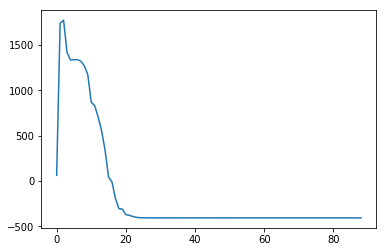

In [18]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [19]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [20]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 1.162011 0.162011 0.162011
1: 0.500000 0.707722 0.207722 0.415443
2: 0.400000 0.390066 -0.009934 -0.024834
3: 2.000000 2.076483 0.076483 0.038241
4: 0.100000 0.160847 0.060847 0.608473
5: 2.000000 2.042650 0.042650 0.021325
6: 3.000000 3.011212 0.011212 0.003737
7: 0.200000 0.190454 -0.009546 -0.047730
8: 4.000000 4.019213 0.019213 0.004803
Status: 4
Cost: -406.858737 (expected: -0.000000)


In [21]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


In [22]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 9 numerical, 0 proportionality, 0 offset, 0 sigma
CRITICAL: Assertion parameters.size() == (unsigned) hierarchical.numParameters() in /home/dweindl/src/parPE/amici/src/standaloneSimulator.cpp:77 failed ()
Aborted (core dumped)


In [23]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

OSError: Unable to open file (truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2144)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [ ]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 1
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/max_iter 100
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_obj_change_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s retryOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


In [ ]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


In [ ]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


In [ ]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [ ]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

In [ ]:
list(model.getParameterNames())

In [ ]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

In [ ]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
plotCorrelation(ymes, ysim)

In [ ]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [ ]:
!cp example_data.h5 example_data_ceres.h5
!../../../misc/optimizationOptions.py example_data_ceres.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data_ceres.h5


In [ ]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

## Minibatch optimization

In [ ]:
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s retryOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/batchSize 2
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!../../../misc/optimizationOptions.py {hdf5FileMinibatch}

In [ ]:
!../../../misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

In [ ]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

In [ ]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [ ]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !../../../misc/optimizationOptions.py {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/steadystate/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

In [ ]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [ ]:
?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing

In [ ]:
list(model.getParameterNames())